# Import Libraries

In [1]:
#
import pandas as pd
import numpy as np
import os
import logging
import datetime as dt

#Viz
import matplotlib.pyplot as plt
import seaborn as sns

#ML
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, OneHotEncoder
from sklearn.preprocessing import RobustScaler
import xgboost as xgb
from sklearn.compose import ColumnTransformer

#Metrics
from sklearn.metrics import precision_score, recall_score
from sklearn import metrics

#Validation techniques
from sklearn.model_selection import KFold, train_test_split, StratifiedKFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedShuffleSplit

#ML Models
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, RandomTreesEmbedding, GradientBoostingClassifier

#Sampling lib
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, SVMSMOTE, ADASYN
from imblearn.under_sampling import NearMiss, TomekLinks, OneSidedSelection, NeighbourhoodCleaningRule
from imblearn.under_sampling import RandomUnderSampler, CondensedNearestNeighbour, EditedNearestNeighbours

from imblearn.combine import SMOTEENN
from imblearn.under_sampling import EditedNearestNeighbours

import warnings
warnings.filterwarnings("ignore")

# Import Dataset

In [2]:
class MasterData():
    
    """""
    author = Vineeth Kulkarni
    version = 1.0
    purpose = import dataset and standerdize column names
    """""
    def __init__(self, file_loc, file_type = 'csv'): 
        
        self.df = pd.read_csv(file_loc, delimiter= ',', header= None)
        return
    
    def base_setup(self):
        
        # renaming/Standardizing columns
        self.df.columns = self.df.columns.str.replace(", |-|/", "_", regex=True) # if needed
        
    def replace_values(self, column_name, value, replace_value):
        """""
        column_name = column name
        value =  value to be changed
        replace_value = new value
        """""
        #replacing a specific value with a given value
        self.df.loc[self.df[column_name] == value, column_name] = replace_value
        

In [3]:
os.chdir('C:\\Users\\vineet.kulkarni\\Downloads\\adult')

In [4]:
#Import Datasets

adult = MasterData('adult.data', file_type= 'csv')
#test = ImportDataset('adult.test', file_type= 'csv')

AS there were no headers for adult dataset we should import it from adult.names

In [5]:
#Importing Adult column names

import_file = open('adult.names', 'r', encoding= 'utf-8-sig')

read_text = import_file.read()
create_list = read_text.split('\n') #split the text for each line

list_of_contents = [i.split(':')[0] for i in create_list if ':' in i]

column_names = [i for i in list_of_contents if not i.startswith('|')]

column_names = column_names + ['Target'] #adding target varibale

In [6]:
#create final data frame

#adult.df.reset_index(drop=True, inplace=True)
adult.df.columns = column_names

In [7]:
# to check columns names with ' ?' symbol
names= []
[names.append(col) for col in adult.df.columns if ' ?' in adult.df[col].unique()]
names

#
for col in names:
    adult.replace_values(col, ' ?', 'Not Available')

# Exploring the variables

In [8]:
adult.df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital-gain    32561 non-null  int64 
 11  capital-loss    32561 non-null  int64 
 12  hours-per-week  32561 non-null  int64 
 13  native-country  32561 non-null  object
 14  Target          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


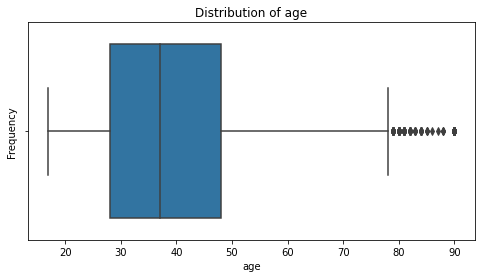

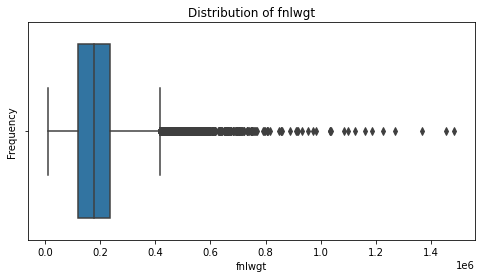

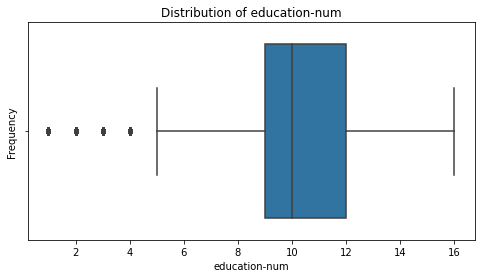

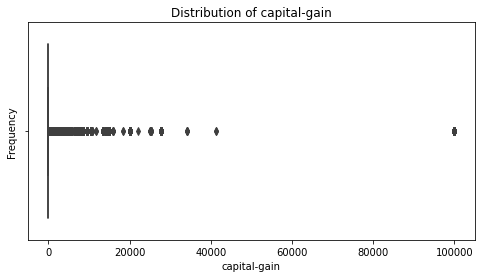

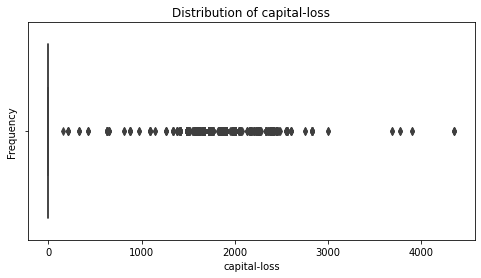

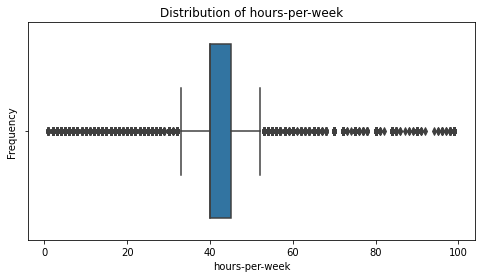

In [9]:
# Create Separate datasets for num and cat data for analysis

numeric_data = adult.df.select_dtypes(include=[np.int64,np.float64])
categorical_data = adult.df.select_dtypes(exclude=[np.int64,np.float64])

# Create distribution plots for each numerical column
for col in numeric_data.columns:
    plt.figure(figsize=(8, 4))
    sns.boxplot(numeric_data[col])
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

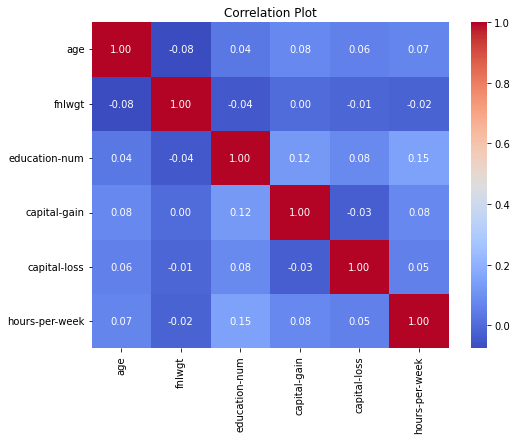

In [10]:
plt.figure(figsize=(8, 6))
sns.heatmap(numeric_data.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Plot")
plt.show()

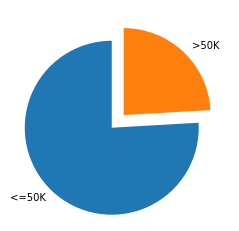

In [11]:
#Checking if there's any imbalance in Dataset

y = dict(categorical_data['Target'].value_counts())
y = list(y.values())

mylabels = list(categorical_data['Target'].unique())
myexplode = [0.2, 0] # explode helps to slide out the mentioned catrgory

plt.pie(y, labels = mylabels, explode = myexplode, startangle= 90)
plt.show() 

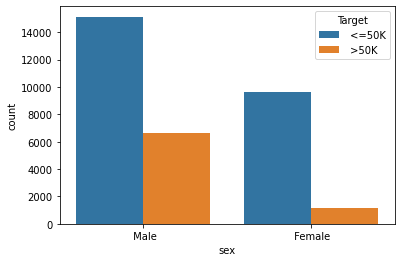

In [12]:
#Checking if there's any imbalance in gender
sns.countplot(x=categorical_data['sex'], hue= categorical_data['Target'])
plt.show()

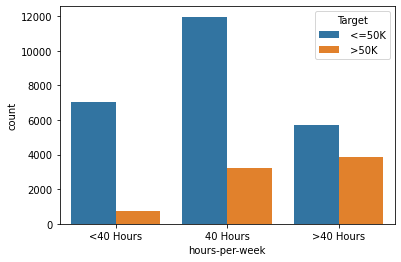

In [13]:
#Checking if there's any imbalance in gender
bins = [0,39,40,100] 
labels = ['<40 Hours' , '40 Hours','>40 Hours'] #Considering 40 hours per week as a standard working hours
numeric_data['hours-per-week'] = pd.cut(numeric_data['hours-per-week'], bins=bins, labels=labels)

sns.countplot(x=numeric_data['hours-per-week'], hue= categorical_data['Target'])
plt.show()

In [14]:
#Headcount by Countries

adult.df['native-country'].value_counts().head()

 United-States    29170
 Mexico             643
Not Available       583
 Philippines        198
 Germany            137
Name: native-country, dtype: int64

1. Variance in Capital-Gain and Capital-Loss is very high compared to other vairables
2. Variables are either skewed or has outliers
3. There's no correlation among variables
4. Select the data for US emp. only. 

In [15]:
adult.df.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'Target'],
      dtype='object')

In [16]:
#Taking a copy of original dataset 
adult_data_copy =adult.df.copy()

#remove unwanted columns
new_df = adult.df.drop(columns= ['fnlwgt', 'capital-gain', 'capital-loss', 'race','education'])

#filter data for United States
new_df = new_df[new_df['native-country'] == ' United-States'] #Considering only US Data

# Data Transform and Train_Test_Split()

In [19]:
#
class DataTransformation:
    
    def __init__(self, data_frame):
        self.data_frame = pd.DataFrame(data_frame)
        return
    
    def train_test_split(self, Target_var, train_size = 0.70):
        return train_test_split(self.data_frame.drop(columns=[Target_var]),
                                self.data_frame[Target_var], train_size=train_size)
        
    def feature_template(self):

        interval_data = self.data_frame.select_dtypes(include=[np.int64,np.float64])
        categorical_data = self.data_frame.drop(columns='Target').select_dtypes(exclude=[np.int64,np.float64])
        #categorical_data = categorical_data.drop(columns=categorical_data['Target'])
        
        return [('interval', RobustScaler(), interval_data.columns),
               ('categorical', OneHotEncoder(handle_unknown='ignore'), categorical_data.columns)]
    
    def transform_data(self):
        template = self.feature_template()
        column_transform = ColumnTransformer(transformers= template)
        
        return column_transform
        

In [49]:
#
transform = DataTransformation(new_df)

#
X_train, X_test, y_train, y_test = transform.train_test_split('Target')

#
column_transform = transform.transform_data()
target_enc = LabelEncoder()

In [50]:
#Fit the col transform

column_transform.fit(X_train)
target_enc.fit(y_train)

LabelEncoder()

In [51]:
#Transform

X_train_trans = column_transform.transform(X_train)
X_test_trans = column_transform.transform(X_test)
y_train_trans = 1-target_enc.transform(y_train)
y_test_trans = 1-target_enc.transform(y_test)

# Sampling the Train Dataset

In [52]:
# Set the ratio

over = SMOTE(sampling_strategy = 0.6)
under = RandomUnderSampler(sampling_strategy=0.7)

In [53]:
X_train_trans, y_train_trans = over.fit_resample(X_train_trans, y_train_trans)
X_train_trans, y_train_trans = under.fit_resample(X_train_trans, y_train_trans)

In [54]:
##

unique, counts = np.unique(y_train_trans, return_counts= True)

dict(zip(unique, counts))

{0: 9252, 1: 13217}

# Model Training

In [55]:
model_list = {
    "logistic_regression": {
        "model": LogisticRegression(),
        "params": {
            "max_iter": [10000],
            "solver": ["newton-cg", "lbfgs", "liblinear"],
            "penalty": ["none", "l1", "l2", "elasticnet"],
            "C": [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]
        }
    },
    "random_forest": {
        "model": RandomForestClassifier(),
        "params": {
            "bootstrap": [True],
            "max_depth": [2, 3, 4, 5],
            "min_samples_split": [100, 200, 300],
            "max_features": ["auto", "log2", "sqrt"],
            "class_weight": ['balanced_subsample', 'balanced'],
            "n_estimators": [5, 6, 7, 8, 9, 10]
        }
    },
    "xgboost": {
        "model": xgb.XGBClassifier(),
        "params": {
#             "min_samples_split": [100, 200, 300],
            "n_estimators": [5, 6, 7, 8, 9, 10, 14, 15],
            
            "max_depth": [2, 3, 4, 5]
        }
    }
}

In [56]:
class ModelBuilding:
    
    def __init__(self, model_list, X_train, y_train, X_test, y_test):
        
        self.model_list  = model_list
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.trained_list = dict()
    
    def model_config(self,cv=5):
        """""
        As there's a imbalance in dataset we'll go with Stratified K Fold CV technique
        """""
        skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
        
        for model in self.model_list:
            random_cv = RandomizedSearchCV(estimator= model_list[model]['model'], param_distributions= model_list[model]['params'], cv = skf)
            random_cv.fit(self.X_train, self.y_train)
            self.trained_list[model] = random_cv
            
        return
    
    def model_train(self):
        for trained_model in self.trained_list:
            model = self.trained_list[trained_model]
            model_pred = model.predict(self.X_train)
            
            #Metrics
            score_train_acc = model.score(self.X_train, self.y_train)
            prec_train = precision_score(self.y_train, model_pred)
            recall_train = recall_score(self.y_train, model_pred)
            
            #model metrics outputs
            print(f'{trained_model}_train_Accuracy:',score_train_acc)
            print(f'{trained_model}_train_Precision:',prec_train)
            print(f'{trained_model}_recall_Precision:',recall_train)
            
            #confusion matrix
            confusion_matrix = metrics.confusion_matrix(self.y_train, model_pred)
            cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
            cm_display.plot()
            plt.title(f'{trained_model}')
            plt.show()
            
        return
    
    def model_test(self):
        for trained_model in self.trained_list:
            model = self.trained_list[trained_model]
            model_pred = model.predict(self.X_test)
            
            #Metrics
            score_train_acc = model.score(self.X_test, self.y_test)
            prec_train = precision_score(self.y_test, model_pred)
            recall_train = recall_score(self.y_test, model_pred)
            
            #model metrics outputs
            print(f'{trained_model}_test_Accuracy:',score_train_acc)
            print(f'{trained_model}_test_Precision:',prec_train)
            print(f'{trained_model}_test_Precision:',recall_train)
            
            #confusion matrix
            confusion_matrix = metrics.confusion_matrix(self.y_test, model_pred)
            cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
            cm_display.plot()
            plt.title(f'{trained_model}')
            plt.show()
            
        return
    
            

In [57]:
# 
model_implement = ModelBuilding(model_list, X_train_trans, y_train_trans, X_test_trans, y_test_trans)

In [58]:
#
model_implement.model_config()

logistic_regression_train_Accuracy: 0.8049312385953981
logistic_regression_train_Precision: 0.8377944325481799
logistic_regression_recall_Precision: 0.8288567753650602


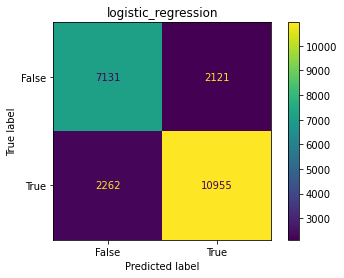

random_forest_train_Accuracy: 0.7827673683742045
random_forest_train_Precision: 0.892171622130222
random_forest_recall_Precision: 0.7174093969887266


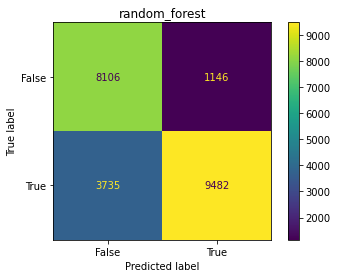

xgboost_train_Accuracy: 0.8400462859940362
xgboost_train_Precision: 0.8843358095694545
xgboost_recall_Precision: 0.8376333509873648


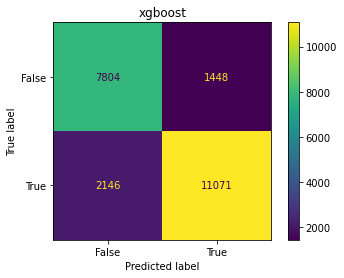

In [59]:
model_implement.model_train()

logistic_regression_test_Accuracy: 0.8089361215861044
logistic_regression_test_Precision: 0.912962962962963
logistic_regression_test_Precision: 0.8244147157190636


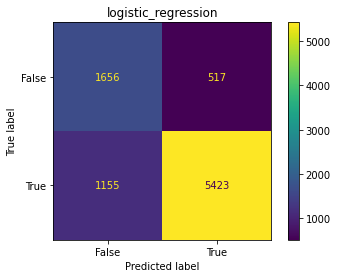

random_forest_test_Accuracy: 0.7497428865272541
random_forest_test_Precision: 0.9334255235084946
random_forest_test_Precision: 0.7183034356947401


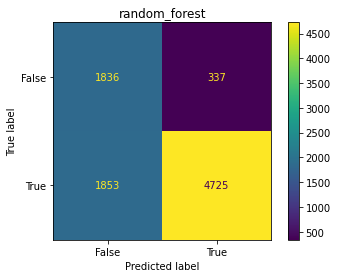

xgboost_test_Accuracy: 0.8124785738772712
xgboost_test_Precision: 0.9123100050108569
xgboost_test_Precision: 0.8303435694740042


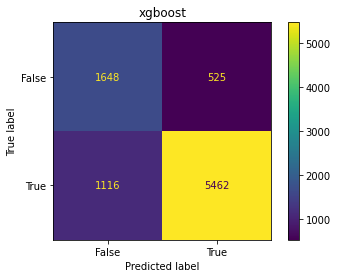

In [60]:
model_implement.model_test()

Xgboost is working better compared to other models.

In [64]:
cv = 5
skf = StratifiedKFold(n_splits=cv, random_state=42, shuffle= True)
trained_list = dict()

for model in model_list:
    random_cv = RandomizedSearchCV(estimator= model_list[model]['model'], param_distributions= model_list[model]['params'], cv = skf)
    random_cv.fit(X_train_trans, y_train_trans)
    trained_list[model] = random_cv

In [68]:
for model in model_list:
    print(model_list[model]['model'])

LogisticRegression()
RandomForestClassifier()
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=None,
              reg_alpha=None, reg_lambda=None, ...)
